In [16]:
import functools as ft
import os

import equinox as eqx
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from einops import repeat
from ipywidgets import interact
from jax import config, device_count, random
from scipy import constants
from tqdm import tqdm

from ising.primitives2 import get_hamiltonian
from ising.state import Environment, State
from ising.types import Algorithm, BCMode
from ising.utils import beta_to_temp
from ising.utils.random import EasyKey

# CPU cores as separate devices
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={os.cpu_count()}'

config.update('jax_platform_name', 'cpu')
config.update("jax_platforms", "cpu")
# config.update("jax_enable_x64", True)
# config.update("jax_check_tracer_leaks", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

%load_ext autoreload
%autoreload 2

if 'profiler_is_running' not in globals():
    profiler_is_running = False    
        
    import jax.profiler
    jax.profiler.start_server(9999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Init
k = EasyKey(np.random.randint(0, 10**10))
rng_key = random.PRNGKey(np.random.randint(0, 10**10))

spin = 0.5
dimensions = 2
size = 32

ENVIRONMENT_BASE_PARAMS = {
    # Beta
    "interaction_bilinear": 1.0,
    "interaction_biquadratic": 0.0,
    "interaction_anisotropy": 0.0,
    "interaction_bicubic": 0.0,
    "interaction_external_field": 0.0,
    "nuclear_magnetic_moment": 1.0,
    "algorithm": Algorithm.GLAUBER,
    "bc_mode": BCMode.PERIODIC,
    "bc_mode_value": None,
}

BETA_MIN = 0.5
BETA_MAX = 3.0
# BETA_COUNT = 2 ** 5
BETA_COUNT = device_count()
# temperatures = np.geomspace(0.25, 5, 2**6) / constants.Boltzmann * interaction_bilinear
# betas = np.geomspace(0.25, 5, 2**5)
betas = np.geomspace(BETA_MIN, BETA_MAX, BETA_COUNT)

# n_device_samples = device_count()
n_device_samples = 1
n_subsamples = 8
# 5 120 000
# 50 00 000
stepsize_sweeps = 100
n_steps = 50

In [18]:
# Single state
env = Environment.from_spin(spin=spin, beta=0.5, **ENVIRONMENT_BASE_PARAMS)
state = State.uniform_random_square_from_env(
    rng_key=k.new, dimensions=dimensions, size=size, env=env, id_=0
)

state = state.evolve_steps(1000, rng_key=k.new)
state = state.evolve_sweeps(100, rng_key=k.new)
measured = state.measure(rng_key=k.new, num=1, sweeps=10)

get_hamiltonian(state)
state.calculate_energy()
state.calculate_magnetisation_density()
measured.steps

Array([113640], dtype=int32, weak_type=True)

In [19]:
def transforms(in_axes, out_axes):
    def inner(fun):
        fun = eqx.filter_jit(fun)
        fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

        return fun

    return inner


@transforms(in_axes=(0, None, None, None, 0, 0, None), out_axes=0)
def make_states(rng_key, spin, dimensions, size, beta, id_, kwargs):
    env = Environment.from_spin(
        spin=spin,
        beta=beta,
        **kwargs,
    )

    rng_key, k = random.split(rng_key, num=2)

    state = State.minimum_square_from_env(
        rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    )
    # state = State.uniform_random_square_from_env(
    #     rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    # )

    return state


@transforms(in_axes=(None, 0, 0), out_axes=0)
def evolve_states(sweeps, key, state):
    return state.evolve_sweeps(sweeps, key)


@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_states(key, state, num=1, sweeps=0):
    return state.measure(rng_key=key, num=num, sweeps=sweeps)

@transforms(in_axes=(None, 0, 0), out_axes=0)
def evolve_and_measure_states(sweeps, key, state):
    evolve_key, measure_key = random.split(key)
    state = state.evolve_sweeps(sweeps, evolve_key)
    measurement = state.measure(rng_key=measure_key, num=1, sweeps=0)
    
    return state, measurement

In [20]:
shape = (n_device_samples, n_subsamples, *betas.shape)
state_keys = k.shaped(shape)
ids = np.arange(np.prod(shape)).reshape(shape)

_betas = repeat(
    betas,
    "betas -> device_samples subsamples betas",
    device_samples=n_device_samples,
    subsamples=n_subsamples,
)


states = make_states(
    state_keys, spin, dimensions, size, _betas, ids, ENVIRONMENT_BASE_PARAMS
)

evolve_measurements = []
for i in tqdm(range(n_steps)):
    keys = k.shaped(shape)
    states, measurement = evolve_and_measure_states(stepsize_sweeps, keys, states)
    evolve_measurements.append(measurement)

100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


In [21]:
states_list = states.unensamble()

In [22]:
measurement_keys = [
    "steps",
    "state_id",
    "energy",
    "magnetisation_density",
]
measurements = {
    key: [] for key in measurement_keys
}
for step_m in evolve_measurements:
    for key in measurement_keys:
        data = getattr(step_m, key).flatten().tolist()
        measurements[key].extend(data)
    

@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])

    
df = pd.DataFrame(measurements)
df["beta"] = df["state_id"].apply(id_to_beta)
df["temperature"] = 1.0 / df["beta"]
df["abs_magnetisation_density"] = np.abs(df["magnetisation_density"])

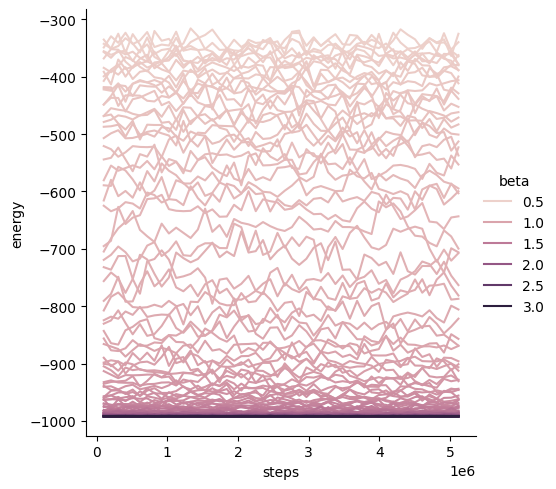

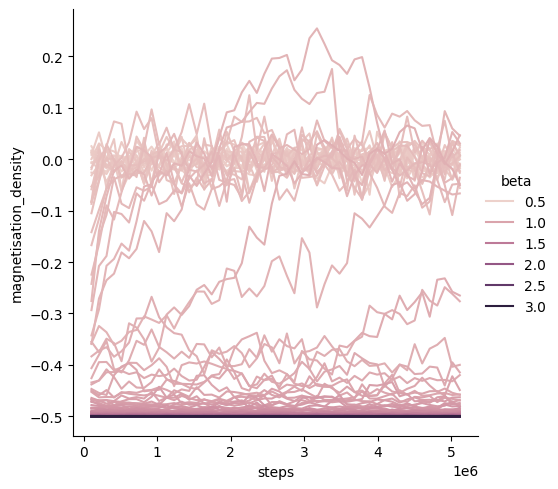

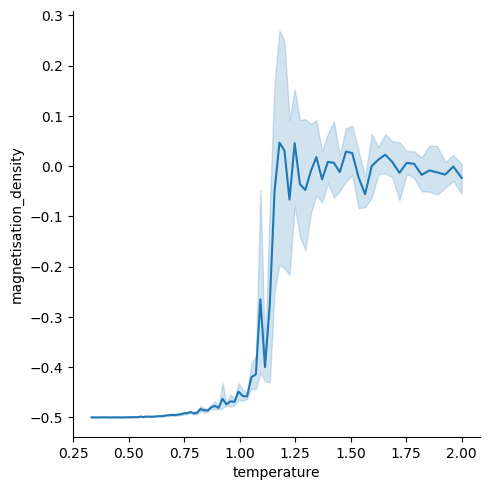

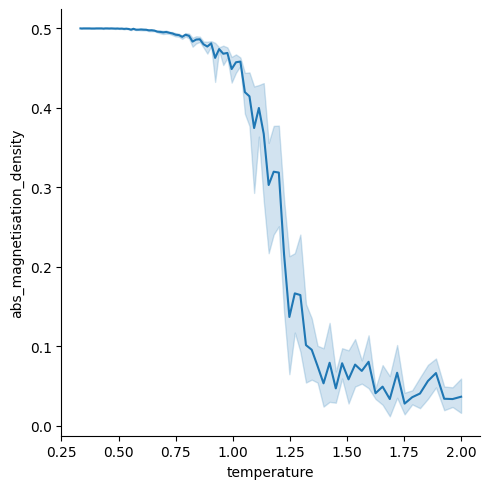

In [23]:
sns.relplot(
    data=df,
    x="steps",
    y="energy",
    hue="beta",
    kind="line",
    errorbar=None
)
sns.relplot(
    data=df,
    x="steps",
    y="magnetisation_density",
    hue="beta",
    kind="line",
    errorbar=None
)
sns.relplot(
    data=df[df["steps"] == np.max(df["steps"])],
    x="temperature",
    y="magnetisation_density",
    # hue="beta",
    kind="line",
    # errorbar=None
)
sns.relplot(
    data=df[df["steps"] == np.max(df["steps"])],
    x="temperature",
    y="abs_magnetisation_density",
    # hue="beta",
    kind="line",
    # errorbar=None
)

In [24]:
temp_states = states_list[:BETA_COUNT]

@interact(value=0, min=0, max=len(temp_states))
def update(i=(0, len(temp_states) - 1)):
    fig = temp_states[i].plot()
    fig.dpi = 500

interactive(children=(IntSlider(value=47, description='i', max=95), Output()), _dom_classes=('widget-interact'…

In [25]:
@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_states(key, state, num=1, sweeps=0):
    return state.measure(rng_key=key, num=num, sweeps=sweeps)

keys = k.shaped(states.vectorisation_shape)
equil_measurements = measure_states(keys, states, 100, 100)

In [ ]:
measurement_keys = [
    "steps",
    "state_id",
    "energy",
    "magnetisation_density",
]
eq_measurements = {
    key: [] for key in measurement_keys
}
for key in measurement_keys:
    data = getattr(equil_measurements, key).flatten().tolist()
    eq_measurements[key].extend(data)
    

@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])

eq_measurements

    
eq_df = pd.DataFrame(eq_measurements)
eq_df["beta"] = eq_df["state_id"].apply(id_to_beta)
eq_df["temperature"] = 1.0 / eq_df["beta"]
eq_df

,steps,state_id,energy,magnetisation_density,beta,temperature
0,5222400,0,-313.0,0.045898,0.5,2.000000
1,5222400,0,-246.0,-0.034180,0.5,2.000000
2,5222400,0,-294.0,0.047852,0.5,2.000000
3,5222400,0,-306.0,0.017578,0.5,2.000000
4,5222400,0,-285.0,-0.021484,0.5,2.000000
...,...,...,...,...,...,...
76795,5222400,767,-992.0,-0.500000,3.0,0.333333
76796,5222400,767,-992.0,-0.500000,3.0,0.333333
76797,5222400,767,-992.0,-0.500000,3.0,0.333333
76798,5222400,767,-992.0,-0.500000,3.0,0.333333


In [ ]:
# Create two dataframes of different 'shapes'
# sin_df: holds data that is defined on every state
# sum_df: holds data that requires grouping on states

sin_df = eq_df.copy()
sin_df["natural_temperature"] = 1.0 / sin_df["beta"]
sin_df["abs_magnetisation_density"] = np.abs(sin_df["magnetisation_density"])

sum_df = pd.DataFrame()


# Energy - Summarised
sum_df["energies_mean"] = eq_df.groupby(["state_id"])["energy"].mean()
sum_df["energies_var"] = eq_df.groupby(["state_id"])["energy"].var()

# Magnetisation Density - Summarised
sum_df["mag_dens_mean"] = eq_df.groupby(["state_id"])["magnetisation_density"].mean()
sum_df["mag_dens_var"] = eq_df.groupby(["state_id"])["magnetisation_density"].var()

# # Index
sum_df["state_id"] = sum_df.index

# Temperature + Coldness
sum_df["beta"] = sum_df["state_id"].apply(id_to_beta)
sum_df["temperature"] = beta_to_temp(sum_df["beta"])
sum_df["natural_temperature"] = 1.0 / sum_df["beta"]

# Heat Capacity
sum_df["heat_cap_gradient"] = np.abs(np.gradient(sum_df["energies_mean"], sum_df["temperature"]))
sum_df["heat_cap_fluctuation"] = sum_df["energies_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Magnetic Susceptibility
sum_df["mag_sus_gradient"] = np.abs(np.gradient(sum_df["mag_dens_mean"], sum_df["temperature"]))
sum_df["mag_sus_fluctuation"] = sum_df["mag_dens_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Binder cumulant
sin_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
sin_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
sin_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

sum_df["mag_1_mean"] = sin_df.groupby("state_id")["mag_1"].mean()
sum_df["mag_2_mean"] = sin_df.groupby("state_id")["mag_2"].mean()
sum_df["mag_4_mean"] = sin_df.groupby("state_id")["mag_4"].mean()


# mag_2_mean = np.mean(mag_2)
# mag_4_mean = np.mean(mag_4)

sum_df["binder_2"] = 1 - sum_df["mag_2_mean"] / np.square(sum_df["mag_1_mean"])
sum_df["binder_4"] = 1.0 / 3.0 - sum_df["mag_4_mean"] / (3.0 * np.square(sum_df["mag_2_mean"]))

In [ ]:
sum_df

,energies_mean,energies_var,mag_dens_mean,mag_dens_var,state_id,beta,temperature,natural_temperature,heat_cap_gradient,heat_cap_fluctuation,mag_sus_gradient,mag_sus_fluctuation,mag_1_mean,mag_2_mean,mag_4_mean,binder_2,binder_4
state_id,,,,,,,,,,,,,,,,,
0,-273.48,697.080404,-0.003340,9.419062e-04,0,0.500000,1.448594e+23,2.000000,1.293165e-22,2.406058e-21,1.695836e-25,3.251105e-27,0.024844,0.000944,0.000002,-5.288779e-01,-5.713564e-01
1,-273.13,734.296061,-0.002881,1.319276e-03,1,0.509520,1.421529e+23,1.962632,1.993980e-21,2.631944e-21,2.019555e-24,4.728693e-27,0.029932,0.001314,0.000005,-4.671035e-01,-5.535232e-01
2,-283.96,628.362020,0.007305,1.250864e-03,2,0.519221,1.394969e+23,1.925963,3.562961e-21,2.338824e-21,1.062889e-26,4.655836e-27,0.029121,0.001292,0.000005,-5.231789e-01,-7.349907e-01
3,-291.93,674.368788,-0.002559,1.217693e-03,3,0.529107,1.368906e+23,1.889978,1.773063e-21,2.606556e-21,6.814680e-25,4.706603e-27,0.028750,0.001212,0.000004,-4.663898e-01,-5.284971e-01
4,-293.24,791.396364,0.003486,1.288467e-03,4,0.539181,1.343329e+23,1.854666,1.964987e-21,3.176478e-21,3.654229e-25,5.171603e-27,0.028096,0.001288,0.000005,-6.313507e-01,-7.238040e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-991.92,0.316768,-0.499980,1.888082e-08,763,2.781999,2.603513e+22,0.359454,4.303928e-23,3.384840e-23,1.050764e-26,2.017522e-30,0.499980,0.249980,0.062490,-7.477391e-08,-9.951167e-08
764,-992.00,0.000000,-0.500000,0.000000e+00,764,2.834967,2.554869e+22,0.352738,3.916144e-23,0.000000e+00,9.560897e-27,0.000000e+00,0.500000,0.250000,0.062500,0.000000e+00,0.000000e+00
765,-991.96,0.160000,-0.499990,9.536743e-09,765,2.888944,2.507134e+22,0.346147,1.595245e-24,1.843663e-23,3.894640e-28,1.098909e-30,0.499990,0.249990,0.062495,-3.776698e-08,-5.025963e-08


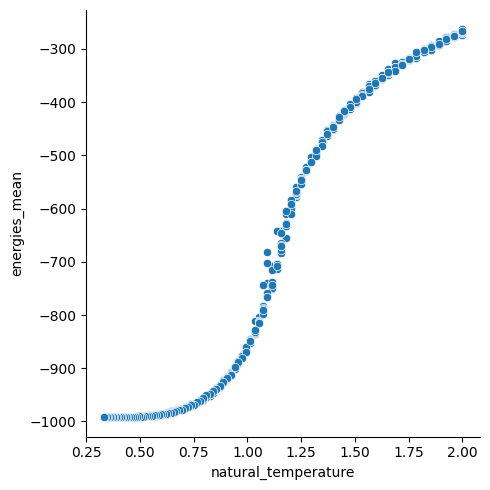

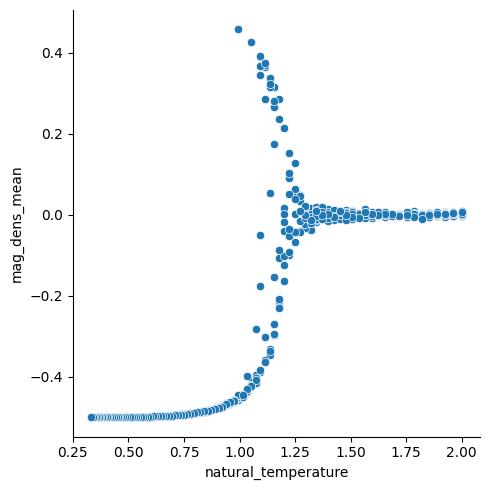

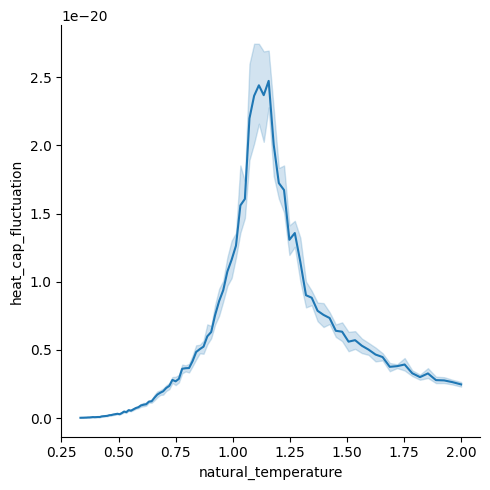

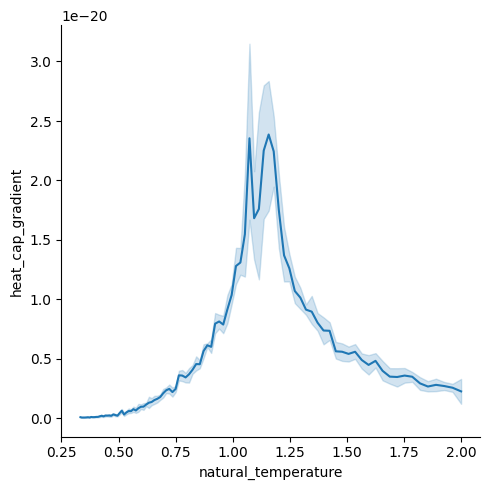

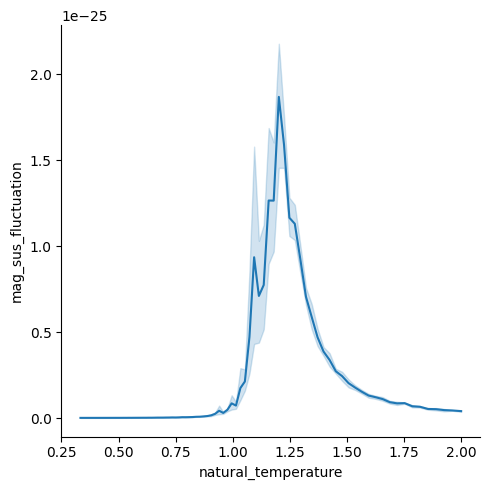

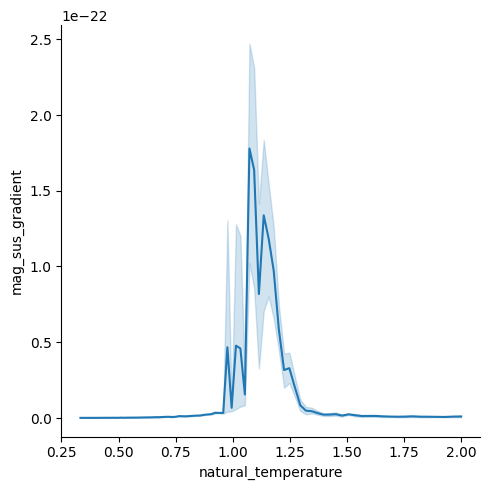

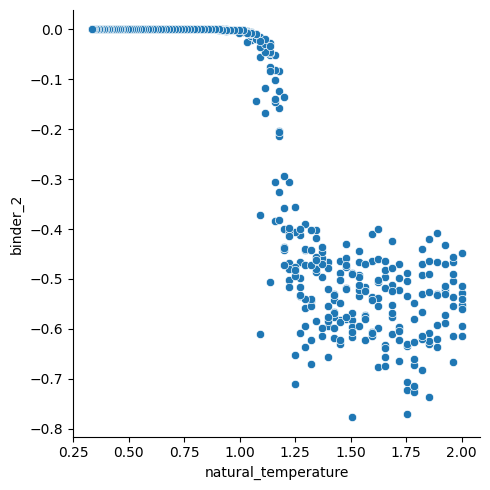

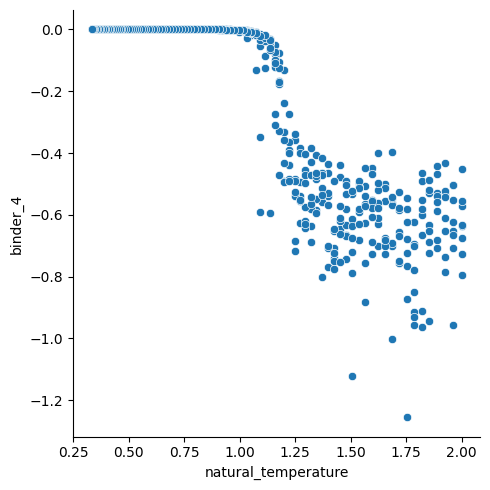

In [ ]:
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="energies_mean",
    # kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_dens_mean",
    # kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_2",
    # kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_4",
    # kind="line",
)

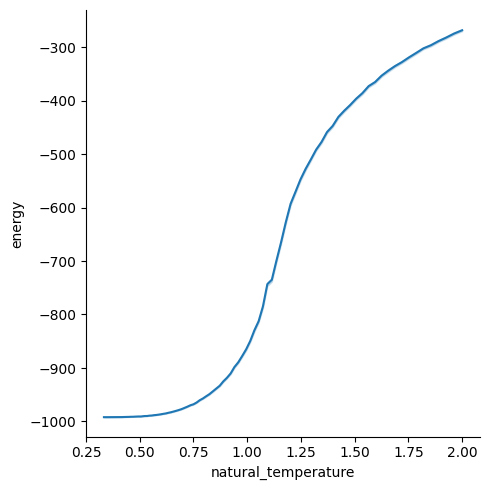

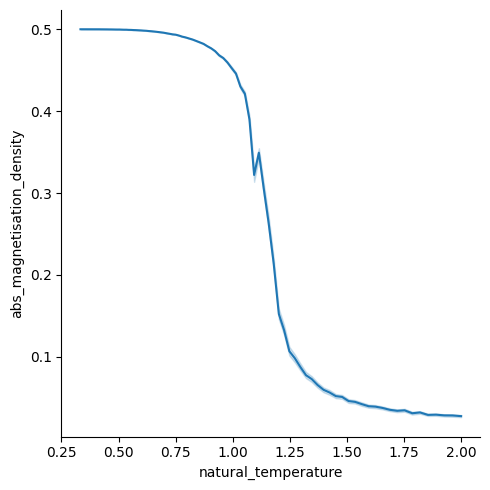

In [ ]:
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="energy",
    kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="abs_magnetisation_density",
    kind="line",
)